# Speech2Text Classification

**Autores: Daniil Panasik & Juan Quer**

## Objetivo

El objetivo de esta práctica es el de reconocer y clasificar la pronunciación de los diferentes números. Es la base con la que funcionan muchos de los Speech2Text más famosos del mercado como el Watson de IBM, pero en este caso implementado desde cero.

Se llevarán acabo diferentes estudios con el fin de cual es el mejor modelo que se adapte a nuestro problema.

Para ello se cuenta con un Dataset de 6 personas diferentes (asegurando escalabilidad) pronunciando diferentes números y con la etiqueta correspondiente para cada número.

## Información adicional

**Sobre el dataset**

Un datset de audio/lenguaje que consta de grabaciones de números en formato WAV sampleados a 8 kHz. Las grabaciones están recortadas, con el fin de eliminar los silencios al principio y al final de cada número.

FSDD es un dataset opensource, lo que le permite ir creciendo con el tiempo mediante las aportaciones de diferentes usuarios. Para su reproducibilidad futura y su citación precisa, hay un control de versiones a través de Zenodo DOI y git tags.

**Current status**

6 locutores

3,000 grabaciones (50 de cada dígito por locutor)

Pronunciación en Inglés

**Organization**

La nomenglatura de los archivos es de la siguiente forma: {digitLabel}_{speakerName}_{index}.wav 

Example: 7_jackson_32.wav

**Metadata**

metadata.py ccontiene todos los metadatos correspondientes a los locutores, géneros y acentos.

## Librerías

In [53]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

import librosa 
import librosa.display
import numpy as np
import pandas as pd
from os import listdir

from os.path import isfile, join

import ast
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, Conv2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
import keras
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 
from sklearn import metrics 

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

# Modelo 1 - DNN con Samples

Lo pongo en español, traducirlo luego: la idea es tener una red DNN cuya entrada sean las muestras temporales de audio para analizar si únicamente con la forma de las ondas es posible clasificar o no.

In [2]:
file = open("free-spoken-digit-dataset-master/metadata.py", 'r')
contents = file.read()
dictionary = ast.literal_eval(contents)
metadata=pd.DataFrame.from_dict(dictionary)

Todos los locutores son de habla inglesa, de género masculino, pero con diferentes acentos:

In [3]:
metadata

,jackson,nicolas,theo,yweweler,george,lucas
gender,male,male,male,male,male,male
accent,USA/neutral,BEL/French,USA/neutral,DEU/German,GRC/Greek,DEU/German
language,english,english,english,english,english,english


## Análisis

Comenzaremos representando la forma de onda de la pronunciación del 0 por dos persona distintas:

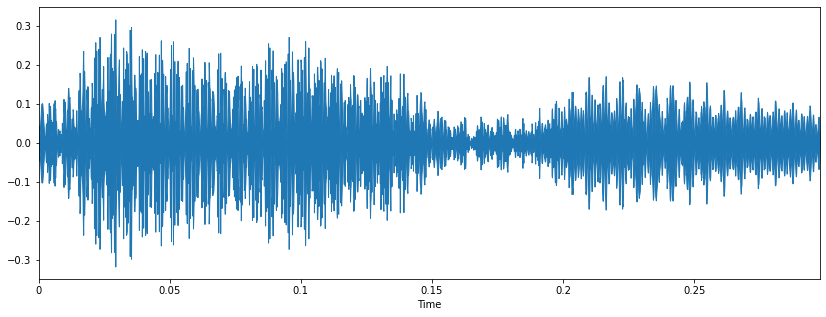

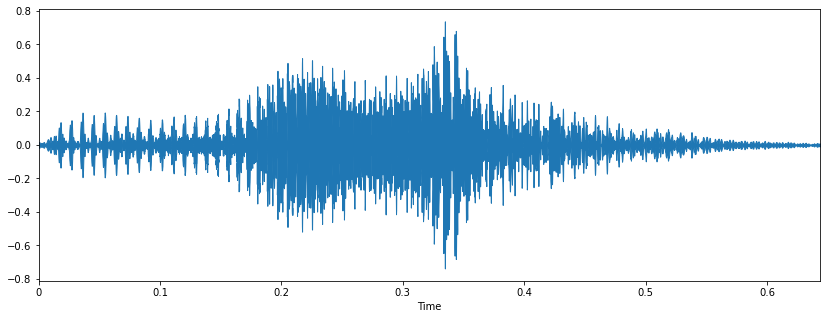

In [4]:
# Grafico 1
filename='free-spoken-digit-dataset-master/recordings/0_george_0.wav'
sr=8000 #8 KHz
audio, sample_rate = librosa.load(filename, sr=sr) 

plt.figure(figsize=(14, 5))
librosa.display.waveplot(audio, sr=sample_rate)

# Grafico 2
filename='free-spoken-digit-dataset-master/recordings/0_jackson_0.wav'
sr=8000 #8 KHz
audio, sample_rate = librosa.load(filename, sr=sr) 

plt.figure(figsize=(14, 5))
librosa.display.waveplot(audio, sr=sample_rate)

Se pueden apreciar dos cosas del gráfico anterior:
- La longitud del segundo es más grande que la del primero, por tanto será necesario rellenar con ceros la más corta (Padding)
- Las formas no son exactamente iguales, pero presentan ciertas simulitudes, por ejemplo el instante [0 - 0.15] guarda un parecido con el instante [0.18 - 0,35] del segundo.

## Preprocesado

Extracción de característcas para cada uno de los audios de nuestro Dataset

In [5]:
# Set the path to the full dataset 
fulldatasetpath = 'free-spoken-digit-dataset-master/recordings/'

onlyfiles = [fulldatasetpath+f for f in listdir(fulldatasetpath) if isfile(join(fulldatasetpath, f))]

features=[] #As padding will be needed, I will store each array's shape in this matrix

sr=8000 #8 KHz

#Iteration over each file
for i in onlyfiles:
    audio, sample_rate = librosa.load(i, sr=sr) 
    #We select the number = class_label
    class_label = i.split("/")[-1].split("_")[0]
    features.append([audio, class_label, audio.shape[0]])
    
# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label','array_len'])

print('La extracción de características ha terminado: ', len(featuresdf), ' archivos procesados') 

La extracción de características ha terminado:  3000  archivos procesados


Representamos en el siguiente DF el resultado de las transformaciones anteriores:

In [6]:
featuresdf.head(7)

,feature,class_label,array_len
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0078125...",5,2699
1,"[9.1552734e-05, -0.0005187988, -6.1035156e-05,...",3,2446
2,"[-0.0005493164, -0.00048828125, -0.00048828125...",1,2696
3,"[-0.0014953613, -0.0008239746, 0.001159668, -0...",2,2556
4,"[0.0, 9.1552734e-05, 9.1552734e-05, 0.00018310...",4,3065
5,"[9.1552734e-05, 0.00018310547, 0.00015258789, ...",3,2272
6,"[-9.1552734e-05, -0.00045776367, 0.00018310547...",4,2898


## Convert the data and labels
Se codifican los codifican los textos a numérico para que pueda ser entendible por el modelos a través de la librería: `sklearn.preprocessing.LabelEncoder`

Preprocesado de los datos:
- Normalización de los valores
- Aleatorización
- Padding para normalizar y tener un tamaño único
- Cerciorarse del correcto formato de las etiquetas

In [7]:
# Aleatorizacion de la muestra
featuresdf =featuresdf.sample(frac=1).reset_index(drop=True)

In [8]:
def normalize(array, a, b):
    # DEscripcion: Funcion para normalizar los datos de un array
    
    ## INPUT ##
    # array: vecto que se quiere normalizar
    # a: minimo
    # b: maximo
    ## OUTPUT ##
    # lista con los valores normalizados
    
    return (b-a)*(array-array.min())/ (array.max() - array.min()) + a

In [9]:
#featuresdf['feature']=featuresdf['feature'].map(lambda x: normalize(x,-1,1))

In [10]:
#Min values: -1, Max values = 1
for index, row in featuresdf.iterrows():
    featuresdf.at[index,'feature']=normalize(row.feature,-1,1)

In [11]:
featuresdf.head()

,feature,class_label,array_len
0,"[-0.07692307, -0.11538464, -0.07692307, -0.115...",9,3539
1,"[0.162395, 0.16102517, 0.16873944, 0.17472339,...",7,3562
2,"[0.18606412, 0.18606412, 0.15684974, 0.1126028...",1,2890
3,"[0.21739125, 0.17566979, 0.21442688, 0.1794027...",7,3379
4,"[0.11655331, 0.11734915, 0.11648095, 0.1172767...",4,4651


**Padding**

Se busca el registro más largo y se añaden ceros al resto para mantener el tamaño en las muestras.

18262 es el número más alto de muestras en un fichero

In [12]:
max_len=max(featuresdf.array_len)
max_len
featuresdf["features_no_padding"]=featuresdf.feature
for index, row in featuresdf.iterrows():
    if row.array_len < max_len:
        featuresdf.at[index,'feature']=np.append(np.zeros(max_len-len(row.feature)),row.feature)

Comprobación de Padding:

In [13]:
record_len = [len(i) for i in featuresdf.feature]
print("Length is right? " + str(record_len[0]==max_len))
print("Right for all elements? " + str(np.all(record_len)))

Length is right? True
Right for all elements? True


In [14]:
# Dropping unneccesary columns
featuresdf = featuresdf.drop(['array_len'],axis=1)

In [15]:
# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

## Modelo

**División Train/Test**

Here we will use `sklearn.model_selection.train_test_split` to split the dataset into training and testing sets. The testing set size will be 20% and we will set a random state. 


In [16]:
# split the dataset 
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)
print(len(x_train))
print(len(x_train[1]))

2400
18262


Este primer intento busca emplear un DNN, odnde la entrada sean las muestras de audio (el volumen) y ver si esto es suficiente para poder llevar a cabo la clasificación.

De esta forma la entrada será muy grande: recordemos el padding que se ha hecho anteriormente que nos llevaba a 18262 muestras.

In [17]:
num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()

##### PONGO 18262 DE INPUT 
model.add(Dense(512, input_shape=(len(x_train[1]),)))
model.add(Activation('relu')) #sigmoid
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu')) #sigmoid 
model.add(Dropout(0.5))

model.add(Dense(128))
model.add(Activation('relu')) #sigmoid 
model.add(Dropout(0.5))


model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [18]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

In [19]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               9350656   
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               3

## Training 

Se va a entrenar el modelo. Empezamos con **100 épocas** que define el número de veces que se van a recorrer los datos. Y un **batch size de 20**, que son el número de registros que introducimos a la red: no interesa que sea grande porque si no no va a saber generalizar.

In [20]:
num_epochs = 100
num_batch_size = 24

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_mlp.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
100/100 [==============================] - 5s 45ms/step - loss: 2.6584 - accuracy: 0.0996 - val_loss: 2.2849 - val_accuracy: 0.1250

Epoch 00001: val_loss improved from inf to 2.28486, saving model to saved_models/weights.best.basic_mlp.hdf5
Epoch 2/100
100/100 [==============================] - 4s 38ms/step - loss: 2.4143 - accuracy: 0.1217 - val_loss: 2.2835 - val_accuracy: 0.1417

Epoch 00002: val_loss improved from 2.28486 to 2.28348, saving model to saved_models/weights.best.basic_mlp.hdf5
Epoch 3/100
100/100 [==============================] - 4s 38ms/step - loss: 2.3745 - accuracy: 0.1333 - val_loss: 2.2970 - val_accuracy: 0.1367

Epoch 00003: val_loss did not improve from 2.28348
Epoch 4/100
100/100 [==============================] - 4s 39ms/step - loss: 2.3336 - accuracy: 0.1163 - val_loss: 2.2886 - val_accuracy: 0.1617

Epoch 00004: val_loss did not improve from 2.28348
Epoch 5/100
100/100 [==============================] - 4s 39ms/step - loss: 2.3229 - accuracy: 0


Epoch 00079: val_loss did not improve from 2.12150
Epoch 80/100
100/100 [==============================] - 4s 39ms/step - loss: 0.5821 - accuracy: 0.7937 - val_loss: 2.9947 - val_accuracy: 0.2683

Epoch 00080: val_loss did not improve from 2.12150
Epoch 81/100
100/100 [==============================] - 4s 39ms/step - loss: 0.6079 - accuracy: 0.7929 - val_loss: 2.9066 - val_accuracy: 0.2400

Epoch 00081: val_loss did not improve from 2.12150
Epoch 82/100
100/100 [==============================] - 4s 39ms/step - loss: 0.6264 - accuracy: 0.7962 - val_loss: 2.8941 - val_accuracy: 0.2500

Epoch 00082: val_loss did not improve from 2.12150
Epoch 83/100
100/100 [==============================] - 4s 39ms/step - loss: 0.5758 - accuracy: 0.8071 - val_loss: 2.8505 - val_accuracy: 0.2483

Epoch 00083: val_loss did not improve from 2.12150
Epoch 84/100
100/100 [==============================] - 4s 39ms/step - loss: 0.6119 - accuracy: 0.8062 - val_loss: 2.8600 - val_accuracy: 0.2517

Epoch 00084: v

In [21]:
# Recrea exactamente el mismo modelo solo desde el archivo
model = keras.models.load_model('model_parte1_bien.h5')

# Guardar el modelo, si hemos entrenado
# model.save('model_bien_train.h5')

## Resultados/Test

Las siguientes gráficas, tablas y resultados, reflejan que con este approach del modelos, no somos capaces de escalar y se presenta un **elevado overfitting**. Con un 0.97 de precisión en trainning, que no sirve de nada con un 0,27 en el conjunto de test

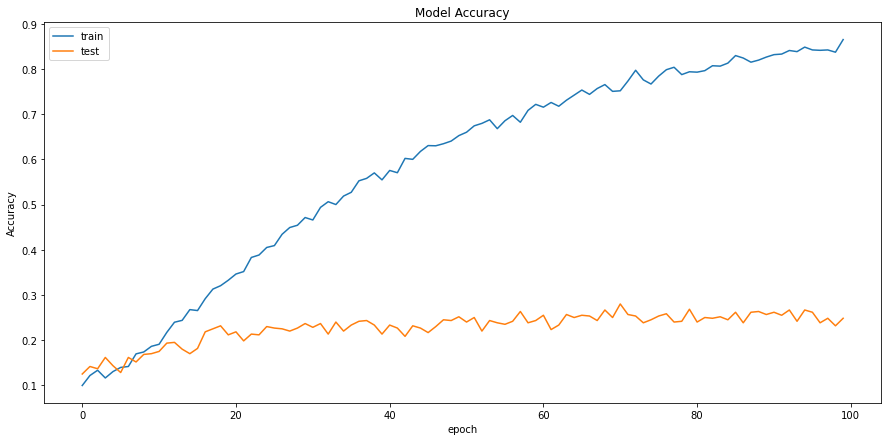

In [22]:
plt.figure(figsize=(15, 7))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.8075000047683716
Testing Accuracy:  0.8116666674613953


In [24]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 512)               9350656   
_________________________________________________________________
activation_19 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               131328    
_________________________________________________________________
activation_20 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)              

# Modelo 2 - DNN Espectograma


Con el fin de mejorar las gráficas del modelo anterior, se plantea otra visión. El enfoque de este modelo es diferente, ya que en vez de trabajar directamente con la muestra, se va hacer a partir de un espectograma.

## Espectograma por grabación

Lo que se va a hacer ahora es sacar el espectograma para cada una de las grabaciones del dataset, pero antes vamos a hacer una representación de una individual para saber con qué estamos tratando. Recordemos, que un espectograma es un gráfico de 3 dimensiones, el eje X es el tiempo, el Y la frecuencia y fianlmente el Z (color) la amplitud-

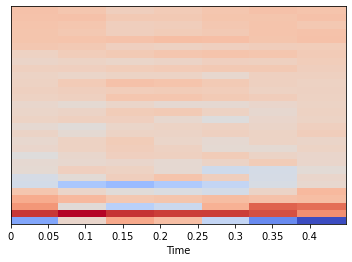

In [25]:
mfccs = librosa.feature.mfcc(y=featuresdf.features_no_padding[0], sr=sr, n_mfcc=30) 
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

In [26]:
#MFCC + mean. At mean execution we make sure that the output is an array and not a matrix
def extract_features_mean(df_row):
    audio = df_row.features_no_padding
    sample_rate= sr
#    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=30)
    mfccsscaled = np.mean(mfccs.T,axis=0)
#    pad_width = max_len - mfccsscaled.shape[0]
#    mfccsscaled_padding = np.pad(mfccsscaled, pad_width=(0, pad_width), mode='constant')
         
    return mfccsscaled

In [28]:
mfcc_mean=[]
for index, row in featuresdf.iterrows():
    mfcc_mean.append(extract_features_mean(row))

In [30]:
featuresdf['mfcc_mean']=mfcc_mean

Se necesita saber el tamaño de salida del espectograma, para poder especificarlo como entrada de la DNN:

Tamaño de entrada = (1080,)

In [31]:
featuresdf.mfcc_mean[0].shape

(30,)

In [32]:
featuresdf.head()

,feature,class_label,features_no_padding,mfcc_mean
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9,"[-0.07692307, -0.11538464, -0.07692307, -0.115...","[-39.483803, 60.535915, 8.433569, 9.575404, -8..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7,"[0.162395, 0.16102517, 0.16873944, 0.17472339,...","[-92.95204, 79.471825, 7.0729437, 28.030212, -..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,"[0.18606412, 0.18606412, 0.15684974, 0.1126028...","[-41.702183, 39.336124, -39.355125, -33.480957..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7,"[0.21739125, 0.17566979, 0.21442688, 0.1794027...","[-73.70272, 15.193558, -14.844714, 11.969907, ..."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4,"[0.11655331, 0.11734915, 0.11648095, 0.1172767...","[-172.33214, 114.60298, 10.373366, -11.781367,..."


## Conversión de etiquetas y datos

In [34]:
# Convert features and corresponding classification labels into numpy arrays
X_2 = np.array(featuresdf.mfcc_mean.tolist())
y_2 = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy_2 = to_categorical(le.fit_transform(y_2)) 

## Modelo

Como de costumbre dividimos nuestros datos entre conjunto de entrenamiento y conjunto de test con un ratio de 80% y 20% de forma totalmente aleatoria


In [35]:
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(X_2, yy_2, test_size=0.2, random_state = 42)

In [36]:
num_labels = yy_2.shape[1]
filter_size = 2

# Construct model 
model_2 = Sequential()

##### PONGO 30 DE INPUT 
model_2.add(Dense(512, input_shape=(30,)))
model_2.add(Activation('relu')) #sigmoid
model_2.add(Dropout(0.5))

model_2.add(Dense(256))
model_2.add(Activation('relu')) #sigmoid 
model_2.add(Dropout(0.5))

model_2.add(Dense(128))
model_2.add(Activation('relu')) #sigmoid 
model_2.add(Dropout(0.5))

model_2.add(Dense(num_labels))
model_2.add(Activation('softmax'))

In [37]:
# Compile the model
model_2.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

In [25]:
# Display model architecture summary 
model_2.summary()

# Calculate pre-training accuracy 
score = model_2.evaluate(x_test_2, y_test_2, verbose=0)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               15872     
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               3

## Training 

En este apartado se va a llevar a cabo el entrenamiento del modelo

In [38]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 400
num_batch_size = 5

checkpointer_2 = ModelCheckpoint(filepath='saved_models/weights.best.basic_mlp_2.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history_2 = model_2.fit(x_train_2, y_train_2, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test_2, y_test_2), callbacks=[checkpointer_2], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/400
480/480 [==============================] - 1s 1ms/step - loss: 8.2188 - accuracy: 0.1438 - val_loss: 2.0698 - val_accuracy: 0.3017

Epoch 00001: val_loss improved from inf to 2.06982, saving model to saved_models/weights.best.basic_mlp_2.hdf5
Epoch 2/400
480/480 [==============================] - 1s 1ms/step - loss: 2.2766 - accuracy: 0.2066 - val_loss: 1.5670 - val_accuracy: 0.4733

Epoch 00002: val_loss improved from 2.06982 to 1.56703, saving model to saved_models/weights.best.basic_mlp_2.hdf5
Epoch 3/400
480/480 [==============================] - 1s 1ms/step - loss: 1.8715 - accuracy: 0.3394 - val_loss: 1.1604 - val_accuracy: 0.6483

Epoch 00003: val_loss improved from 1.56703 to 1.16037, saving model to saved_models/weights.best.basic_mlp_2.hdf5
Epoch 4/400
480/480 [==============================] - 1s 1ms/step - loss: 1.5218 - accuracy: 0.4493 - val_loss: 0.9655 - val_accuracy: 0.6617

Epoch 00004: val_loss improved from 1.16037 to 0.96554, saving model to saved_model

480/480 [==============================] - 0s 1ms/step - loss: 0.3204 - accuracy: 0.9275 - val_loss: 0.2085 - val_accuracy: 0.9450

Epoch 00078: val_loss did not improve from 0.15625
Epoch 79/400
480/480 [==============================] - 0s 1ms/step - loss: 0.2437 - accuracy: 0.9402 - val_loss: 0.2089 - val_accuracy: 0.9483

Epoch 00079: val_loss did not improve from 0.15625
Epoch 80/400
480/480 [==============================] - 0s 996us/step - loss: 0.3310 - accuracy: 0.9245 - val_loss: 0.2118 - val_accuracy: 0.9500

Epoch 00080: val_loss did not improve from 0.15625
Epoch 81/400
480/480 [==============================] - 0s 1ms/step - loss: 0.2138 - accuracy: 0.9457 - val_loss: 0.2374 - val_accuracy: 0.9500

Epoch 00081: val_loss did not improve from 0.15625
Epoch 82/400
480/480 [==============================] - 1s 1ms/step - loss: 0.3178 - accuracy: 0.9373 - val_loss: 0.2184 - val_accuracy: 0.9467

Epoch 00082: val_loss did not improve from 0.15625
Epoch 83/400
480/480 [=========

480/480 [==============================] - 1s 1ms/step - loss: 0.2953 - accuracy: 0.9496 - val_loss: 0.2429 - val_accuracy: 0.9417

Epoch 00120: val_loss did not improve from 0.15625
Epoch 121/400
480/480 [==============================] - 0s 1ms/step - loss: 0.4015 - accuracy: 0.9398 - val_loss: 0.2140 - val_accuracy: 0.9517

Epoch 00121: val_loss did not improve from 0.15625
Epoch 122/400
480/480 [==============================] - 0s 1ms/step - loss: 0.2437 - accuracy: 0.9467 - val_loss: 0.2029 - val_accuracy: 0.9500

Epoch 00122: val_loss did not improve from 0.15625
Epoch 123/400
480/480 [==============================] - 0s 1ms/step - loss: 0.3691 - accuracy: 0.9520 - val_loss: 0.1925 - val_accuracy: 0.9517

Epoch 00123: val_loss did not improve from 0.15625
Epoch 124/400
480/480 [==============================] - 1s 1ms/step - loss: 0.2514 - accuracy: 0.9480 - val_loss: 0.2548 - val_accuracy: 0.9417

Epoch 00124: val_loss did not improve from 0.15625
Epoch 125/400
480/480 [======


Epoch 00161: val_loss did not improve from 0.15625
Epoch 162/400
480/480 [==============================] - 0s 1ms/step - loss: 0.2074 - accuracy: 0.9582 - val_loss: 0.2860 - val_accuracy: 0.9533

Epoch 00162: val_loss did not improve from 0.15625
Epoch 163/400
480/480 [==============================] - 0s 1ms/step - loss: 0.2560 - accuracy: 0.9506 - val_loss: 0.2828 - val_accuracy: 0.9383

Epoch 00163: val_loss did not improve from 0.15625
Epoch 164/400
480/480 [==============================] - 0s 1ms/step - loss: 0.2520 - accuracy: 0.9430 - val_loss: 0.2778 - val_accuracy: 0.9467

Epoch 00164: val_loss did not improve from 0.15625
Epoch 165/400
480/480 [==============================] - 0s 997us/step - loss: 0.2002 - accuracy: 0.9599 - val_loss: 0.3063 - val_accuracy: 0.9450

Epoch 00165: val_loss did not improve from 0.15625
Epoch 166/400
480/480 [==============================] - 0s 1ms/step - loss: 0.2245 - accuracy: 0.9506 - val_loss: 0.3814 - val_accuracy: 0.9417

Epoch 00166:


Epoch 00244: val_loss did not improve from 0.15625
Epoch 245/400
480/480 [==============================] - 1s 1ms/step - loss: 0.2252 - accuracy: 0.9554 - val_loss: 0.2071 - val_accuracy: 0.9417

Epoch 00245: val_loss did not improve from 0.15625
Epoch 246/400
480/480 [==============================] - 1s 1ms/step - loss: 0.3898 - accuracy: 0.9394 - val_loss: 0.2358 - val_accuracy: 0.9467

Epoch 00246: val_loss did not improve from 0.15625
Epoch 247/400
480/480 [==============================] - 1s 1ms/step - loss: 0.2274 - accuracy: 0.9510 - val_loss: 0.2745 - val_accuracy: 0.9467

Epoch 00247: val_loss did not improve from 0.15625
Epoch 248/400
480/480 [==============================] - 1s 1ms/step - loss: 0.2320 - accuracy: 0.9582 - val_loss: 0.2368 - val_accuracy: 0.9583

Epoch 00248: val_loss did not improve from 0.15625
Epoch 249/400
480/480 [==============================] - 1s 1ms/step - loss: 0.3873 - accuracy: 0.9488 - val_loss: 0.3524 - val_accuracy: 0.9433

Epoch 00249: v


Epoch 00327: val_loss did not improve from 0.15625
Epoch 328/400
480/480 [==============================] - 0s 1ms/step - loss: 0.3638 - accuracy: 0.9431 - val_loss: 0.2649 - val_accuracy: 0.9483

Epoch 00328: val_loss did not improve from 0.15625
Epoch 329/400
480/480 [==============================] - 0s 1ms/step - loss: 0.1873 - accuracy: 0.9640 - val_loss: 0.3442 - val_accuracy: 0.9517

Epoch 00329: val_loss did not improve from 0.15625
Epoch 330/400
480/480 [==============================] - 0s 1ms/step - loss: 0.2084 - accuracy: 0.9637 - val_loss: 0.3441 - val_accuracy: 0.9550

Epoch 00330: val_loss did not improve from 0.15625
Epoch 331/400
480/480 [==============================] - 0s 1ms/step - loss: 0.2696 - accuracy: 0.9546 - val_loss: 0.5005 - val_accuracy: 0.9467

Epoch 00331: val_loss did not improve from 0.15625
Epoch 332/400
480/480 [==============================] - 0s 1ms/step - loss: 0.2466 - accuracy: 0.9600 - val_loss: 0.5926 - val_accuracy: 0.9517

Epoch 00332: v

In [55]:
# Recrea exactamente el mismo modelo solo desde el archivo
#model_2 = keras.models.load_model('model_parte2.h5')

# Guardar el modelo, si hemos entrenado
model_2.save('model_parte2_mean.h5')

## Test the model 

A continuación, se estudiarán las pérdidas y precisión del modelo en el conjunto de entrenamiento frente al de test:

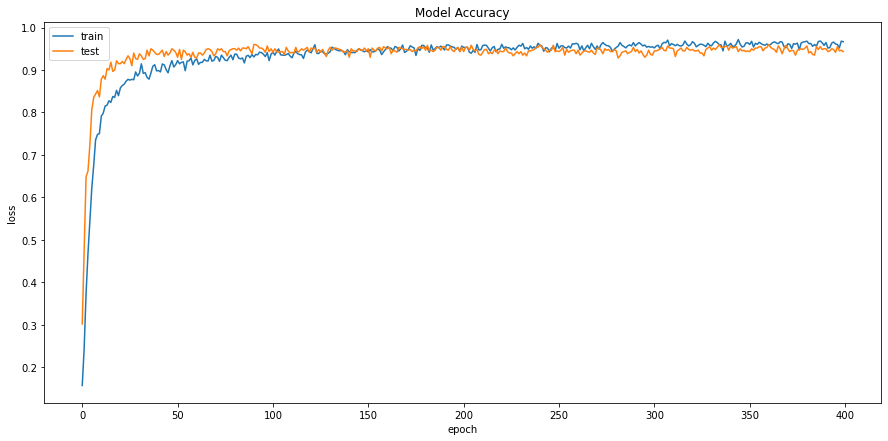

In [42]:
plt.figure(figsize=(15, 7))
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

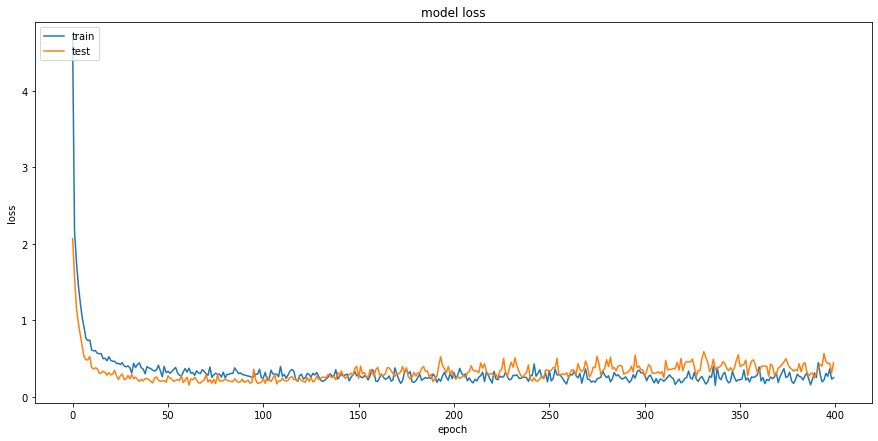

In [39]:
plt.figure(figsize=(15, 7))
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [43]:
# Evaluating the model on the training and testing set
score = model_2.evaluate(x_train_2, y_train_2, verbose=0)
print("Precisión de Train: ", score[1])

score = model_2.evaluate(x_test_2, y_test_2, verbose=0)
print("Precisión de Test: ", score[1])

Precisión de Train:  0.9937499761581421
Precisión de Test:  0.9433333277702332


# Modelo 3 - CNN MFCC

In [44]:
# As for CNN an image is needed, we do not flatten the output
def extract_features(df_row):
    audio = df_row.feature
    sample_rate= sr
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=30)
    return mfccs

In [45]:
mfcc=[]
for index, row in featuresdf.iterrows():
    mfcc.append(extract_features(row))

In [49]:
featuresdf['mfcc']=mfcc
featuresdf.mfcc[0].shape

(30, 36)

Se tiene que saber cual es la salida devuelta por el MFCC para que se pueda asignar la entrada correcta a la CNN:

Tamaño = (30,36)

In [50]:
# Convert features and corresponding classification labels into numpy arrays
X_3 = np.array(featuresdf.mfcc.tolist())
y_3 = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy_3 = to_categorical(le.fit_transform(y_3)) 

# split the dataset 
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(X_3, yy_3, test_size=0.2, random_state = 42)

In [51]:
x_train_3.shape

(2400, 30, 36)

In [54]:
num_rows = 30
num_columns = 36
num_channels = 1

x_train_3 = x_train_3.reshape(x_train_3.shape[0], num_rows, num_columns, num_channels)
x_test_3 = x_test_3.reshape(x_test_3.shape[0], num_rows, num_columns, num_channels)

num_labels = yy_3.shape[1]
filter_size = 2

# Construct model 
model_3 = Sequential()
model_3.add(Conv2D(filters=16, kernel_size=4, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.4))

model_3.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2,2)))
model_3.add(Dropout(0.4))

model_3.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2,2)))
model_3.add(Dropout(0.4))

model_3.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model_3.add(Dropout(0.2))
model_3.add(GlobalAveragePooling2D())

model_3.add(Dense(num_labels, activation='softmax')) 

### Compiling the model 

Se compilará el modelos usando los mismos parámetros empleados en los dos modelos anteriores:

In [56]:
# Compile the model
model_3.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

In [57]:
# Display model architecture summary 
model_3.summary()

# Calculate pre-training accuracy 
score = model_3.evaluate(x_test_3, y_test_3, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 27, 33, 16)        272       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 16, 16)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 13, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 15, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 7, 32)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 6, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 6, 64)         

### Training 

En esta sección, se entrena el modelo. Como el entrenamiento de una CNN puede llevar bastante tiempo, se empezaría con un número bajo de épocas un batch pequeño. Si vemos que el modelo converge, se aumentarán los hiperparámetros anteriores.

In [61]:
num_epochs = 200
num_batch_size = 40

checkpointer_3 = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history_3 = model_3.fit(x_train_3, y_train_3, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test_3, y_test_3), callbacks=[checkpointer_3], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/200
60/60 [==============================] - 1s 11ms/step - loss: 0.5855 - accuracy: 0.7942 - val_loss: 0.3330 - val_accuracy: 0.9117

Epoch 00001: val_loss improved from inf to 0.33298, saving model to saved_models/weights.best.basic_cnn.hdf5
Epoch 2/200
60/60 [==============================] - 1s 11ms/step - loss: 0.6257 - accuracy: 0.7887 - val_loss: 0.3554 - val_accuracy: 0.9050

Epoch 00002: val_loss did not improve from 0.33298
Epoch 3/200
60/60 [==============================] - 1s 11ms/step - loss: 0.5965 - accuracy: 0.7817 - val_loss: 0.3727 - val_accuracy: 0.8967

Epoch 00003: val_loss did not improve from 0.33298
Epoch 4/200
60/60 [==============================] - 1s 11ms/step - loss: 0.6376 - accuracy: 0.7850 - val_loss: 0.3849 - val_accuracy: 0.8967

Epoch 00004: val_loss did not improve from 0.33298
Epoch 5/200
60/60 [==============================] - 1s 11ms/step - loss: 0.6124 - accuracy: 0.7883 - val_loss: 0.3837 - val_accuracy: 0.8900

Epoch 00005: val_loss d

60/60 [==============================] - 1s 13ms/step - loss: 0.6182 - accuracy: 0.7883 - val_loss: 0.3791 - val_accuracy: 0.9017

Epoch 00043: val_loss did not improve from 0.33298
Epoch 44/200
60/60 [==============================] - 1s 14ms/step - loss: 0.6168 - accuracy: 0.7933 - val_loss: 0.3866 - val_accuracy: 0.8933

Epoch 00044: val_loss did not improve from 0.33298
Epoch 45/200
60/60 [==============================] - 1s 14ms/step - loss: 0.5982 - accuracy: 0.7946 - val_loss: 0.3609 - val_accuracy: 0.9050

Epoch 00045: val_loss did not improve from 0.33298
Epoch 46/200
60/60 [==============================] - 1s 14ms/step - loss: 0.5879 - accuracy: 0.7892 - val_loss: 0.3795 - val_accuracy: 0.8883

Epoch 00046: val_loss did not improve from 0.33298
Epoch 47/200
60/60 [==============================] - 1s 13ms/step - loss: 0.5693 - accuracy: 0.7950 - val_loss: 0.3508 - val_accuracy: 0.9017

Epoch 00047: val_loss did not improve from 0.33298
Epoch 48/200
60/60 [==================

60/60 [==============================] - 1s 10ms/step - loss: 0.5681 - accuracy: 0.7983 - val_loss: 0.3484 - val_accuracy: 0.9267

Epoch 00085: val_loss did not improve from 0.33225
Epoch 86/200
60/60 [==============================] - 1s 10ms/step - loss: 0.5596 - accuracy: 0.8100 - val_loss: 0.3464 - val_accuracy: 0.9233

Epoch 00086: val_loss did not improve from 0.33225
Epoch 87/200
60/60 [==============================] - 1s 10ms/step - loss: 0.5632 - accuracy: 0.8037 - val_loss: 0.3507 - val_accuracy: 0.9200

Epoch 00087: val_loss did not improve from 0.33225
Epoch 88/200
60/60 [==============================] - 1s 10ms/step - loss: 0.5656 - accuracy: 0.7979 - val_loss: 0.3386 - val_accuracy: 0.9300

Epoch 00088: val_loss did not improve from 0.33225
Epoch 89/200
60/60 [==============================] - 1s 10ms/step - loss: 0.5337 - accuracy: 0.8213 - val_loss: 0.3445 - val_accuracy: 0.9233

Epoch 00089: val_loss did not improve from 0.33225
Epoch 90/200
60/60 [==================


Epoch 00126: val_loss did not improve from 0.32525
Epoch 127/200
60/60 [==============================] - 1s 10ms/step - loss: 0.5402 - accuracy: 0.8071 - val_loss: 0.3665 - val_accuracy: 0.9167

Epoch 00127: val_loss did not improve from 0.32525
Epoch 128/200
60/60 [==============================] - 1s 10ms/step - loss: 0.5616 - accuracy: 0.8058 - val_loss: 0.3433 - val_accuracy: 0.9050

Epoch 00128: val_loss did not improve from 0.32525
Epoch 129/200
60/60 [==============================] - 1s 10ms/step - loss: 0.5628 - accuracy: 0.8071 - val_loss: 0.3621 - val_accuracy: 0.9117

Epoch 00129: val_loss did not improve from 0.32525
Epoch 130/200
60/60 [==============================] - 1s 10ms/step - loss: 0.5819 - accuracy: 0.8008 - val_loss: 0.3634 - val_accuracy: 0.9100

Epoch 00130: val_loss did not improve from 0.32525
Epoch 131/200
60/60 [==============================] - 1s 10ms/step - loss: 0.5527 - accuracy: 0.8146 - val_loss: 0.3740 - val_accuracy: 0.9033

Epoch 00131: val_lo

60/60 [==============================] - 1s 10ms/step - loss: 0.5515 - accuracy: 0.8096 - val_loss: 0.3488 - val_accuracy: 0.9133

Epoch 00168: val_loss did not improve from 0.32230
Epoch 169/200
60/60 [==============================] - 1s 10ms/step - loss: 0.5662 - accuracy: 0.8138 - val_loss: 0.3497 - val_accuracy: 0.9167

Epoch 00169: val_loss did not improve from 0.32230
Epoch 170/200
60/60 [==============================] - 1s 10ms/step - loss: 0.5546 - accuracy: 0.8075 - val_loss: 0.3409 - val_accuracy: 0.9117

Epoch 00170: val_loss did not improve from 0.32230
Epoch 171/200
60/60 [==============================] - 1s 10ms/step - loss: 0.5728 - accuracy: 0.8075 - val_loss: 0.3436 - val_accuracy: 0.9083

Epoch 00171: val_loss did not improve from 0.32230
Epoch 172/200
60/60 [==============================] - 1s 10ms/step - loss: 0.5533 - accuracy: 0.8096 - val_loss: 0.3915 - val_accuracy: 0.8867

Epoch 00172: val_loss did not improve from 0.32230
Epoch 173/200
60/60 [=============

### Test the model 

Testeamos el modelo represnentando los gráficos de la precisión de entrenamiento frente a la de test. Se puede ver como la precisión del modelo aumenta. Lo curiosos de este caso y que se ha dejado para la practica como curiosidad, es la alta capcidad del modelo por escalar representada en la siguiente imagen.

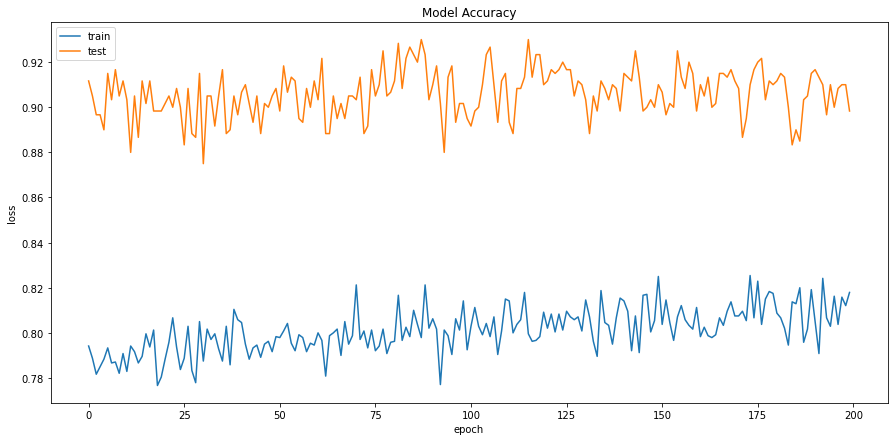

In [63]:
plt.figure(figsize=(15, 7))
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [65]:
# Evaluating the model on the training and testing set
score = model_3.evaluate(x_train_3, y_train_3, verbose=0)
print("Training Accuracy: ", score[1])

score = model_3.evaluate(x_test_3, y_test_3, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9620833396911621
Testing Accuracy:  0.8983333110809326


In [66]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_3 = keras.models.load_model('cnn.h5')

#model_3.save("cnn.h5")

# Conclusiones

Analizando los resultado de los 3 modelos entrenados, se peude ver como el último modelo entrenado con una CNN es el que mejore resulado obtiene en el conjunto de Test. A través de la DNN se obtienen bastante buenos resutlados, mientras que con el primer modelo, en el que apenas se ha hecho ningún preprocesado de los datos, se obtiene como mucho un 0.26 de precisión.